In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    r"D:\code\archive\images\images\train",
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=99
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_dataset = val_datagen.flow_from_directory(
    r"D:\code\archive\images\images\validation",
    target_size=(48, 48),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=99
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [20]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)  # Add dropout layer
output = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Fine-tune some layers of ResNet50
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=4, name="top_k_accuracy")]
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=metrics,
)

In [21]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.2)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=1,
    # callbacks=[early_stopping, reduce_lr, lr_scheduler]
    callbacks=[reduce_lr, lr_scheduler]
)

Epoch 1/100
901/901 [==============================] - 1707s 2s/step - loss: 1.8262 - accuracy: 0.3001 - top_k_accuracy: 0.7811 - val_loss: 1.6156 - val_accuracy: 0.4183 - val_top_k_accuracy: 0.8599
Epoch 2/100
901/901 [==============================] - 1659s 2s/step - loss: 1.4182 - accuracy: 0.4614 - top_k_accuracy: 0.8912 - val_loss: 1.2301 - val_accuracy: 0.5358 - val_top_k_accuracy: 0.9338
Epoch 3/100
901/901 [==============================] - 1711s 2s/step - loss: 1.2979 - accuracy: 0.5041 - top_k_accuracy: 0.9163 - val_loss: 1.1708 - val_accuracy: 0.5635 - val_top_k_accuracy: 0.9437
Epoch 4/100
901/901 [==============================] - 1617s 2s/step - loss: 1.2112 - accuracy: 0.5425 - top_k_accuracy: 0.9310 - val_loss: 1.2011 - val_accuracy: 0.5412 - val_top_k_accuracy: 0.9343
Epoch 5/100
901/901 [==============================] - 1724s 2s/step - loss: 1.1834 - accuracy: 0.5485 - top_k_accuracy: 0.9355 - val_loss: 1.0777 - val_accuracy: 0.5948 - val_top_k_accuracy: 0.9526
Epoch

In [25]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=metrics,
)
# Continue training the model
new_history = model.fit(
    train_dataset,               
    validation_data=val_dataset, 
    epochs=50,                   
    verbose=1,
    callbacks=[reduce_lr, lr_scheduler] 
)


Epoch 1/50
901/901 [==============================] - 1202s 1s/step - loss: 0.9702 - accuracy: 0.6399 - top_k_accuracy: 0.9640 - val_loss: 1.0827 - val_accuracy: 0.6052 - val_top_k_accuracy: 0.9519
Epoch 2/50
901/901 [==============================] - 1166s 1s/step - loss: 0.9889 - accuracy: 0.6262 - top_k_accuracy: 0.9636 - val_loss: 1.0779 - val_accuracy: 0.6097 - val_top_k_accuracy: 0.9590
Epoch 3/50
901/901 [==============================] - 1295s 1s/step - loss: 0.9631 - accuracy: 0.6396 - top_k_accuracy: 0.9671 - val_loss: 1.0491 - val_accuracy: 0.6333 - val_top_k_accuracy: 0.9560
Epoch 4/50
901/901 [==============================] - 1243s 1s/step - loss: 0.9536 - accuracy: 0.6341 - top_k_accuracy: 0.9668 - val_loss: 1.0226 - val_accuracy: 0.6291 - val_top_k_accuracy: 0.9641
Epoch 5/50
901/901 [==============================] - 1183s 1s/step - loss: 0.9445 - accuracy: 0.6450 - top_k_accuracy: 0.9667 - val_loss: 1.0627 - val_accuracy: 0.6190 - val_top_k_accuracy: 0.9605
Epoch 6/50

In [27]:
loss, accuracy, top_k_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')
print(f'Validation top_k_Accuracy: {top_k_accuracy}')


442/442 [==============================] - 45s 101ms/step - loss: 1.0553 - accuracy: 0.6577 - top_k_accuracy: 0.9656
Validation Loss: 1.0552518367767334
Validation Accuracy: 0.6576563715934753
Validation top_k_Accuracy: 0.9656099677085876


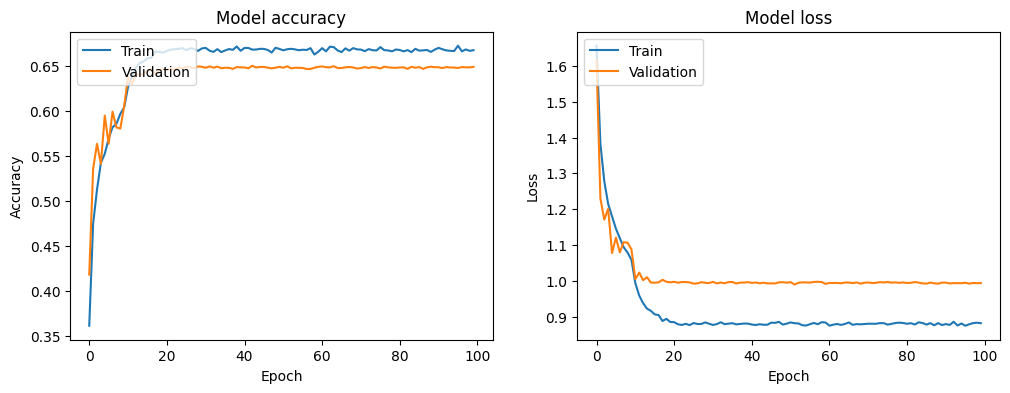

In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)


In [28]:
# Assuming 'model' is your trained model
model.save('resnet_model.h5')  # You can use .h5 or no extension for SavedModel format
